# Determining the Ice thickness of Vatnajokull based on H/V spectral ratio

In [36]:
import csv
import pandas as pd
import matplotlib.pyplot as plt

In [37]:
root = "D:\MEMOIRE\Ice_thickness"
alt_glacier = '\point_altitude_glacier\point_altitude_glacier.csv'
station = "\lt_nodes_ablation_lambert.csv"

In [38]:
with open(root+alt_glacier) as file :
    glac_alt = []
    pos = []
    line = 0
    readcsv = csv.reader(file, delimiter=',')
    for row in readcsv :
        if line > 0 :
            glac_alt.append(float(row[-1]))
            pos.append(float(row[3])/1000)
        line += 1
print(len(pos))
print(len(glac_alt))

1430
1430


In [39]:
filepath = root+station
print(filepath)
with open(filepath) as file :
    stt = []
    readcsv = csv.reader(file, delimiter=',')
    i = 0
    line = 0
    for row in readcsv :
        if line > 0 :
            stt.append([row[1]])
            stt[i].extend(row[4:7])
            i += 1
        line += 1
        
def sortThird(val):
    return val[2]
stt.sort(key=sortThird)

node_alt = []
for line in stt :
    node_alt.append(float(line[3]))

print(len(node_alt))

D:\MEMOIRE\Ice_thickness\lt_nodes_ablation_lambert.csv
6


In [40]:
def distance_station(stt) :
    DIST_orign = [0]
    for i in range(1,len(stt)) :
        diff_X = float(stt[i][1]) - float(stt[i-1][1])
        diff_Y = float(stt[i][2]) - float(stt[i-1][2])
        dist = (diff_X**2+diff_Y**2)**(1/2)
        DIST_orign.append((DIST_orign[i-1]*1000+dist)/1000)
    return DIST_orign
DIST = distance_station(stt)
print(len(DIST))
#print(DIST)

6


###### La oldest ice : Qu'est-ce que c'est ? partir sur où on la trouve, comment on la trouve et quel est l'intéret.

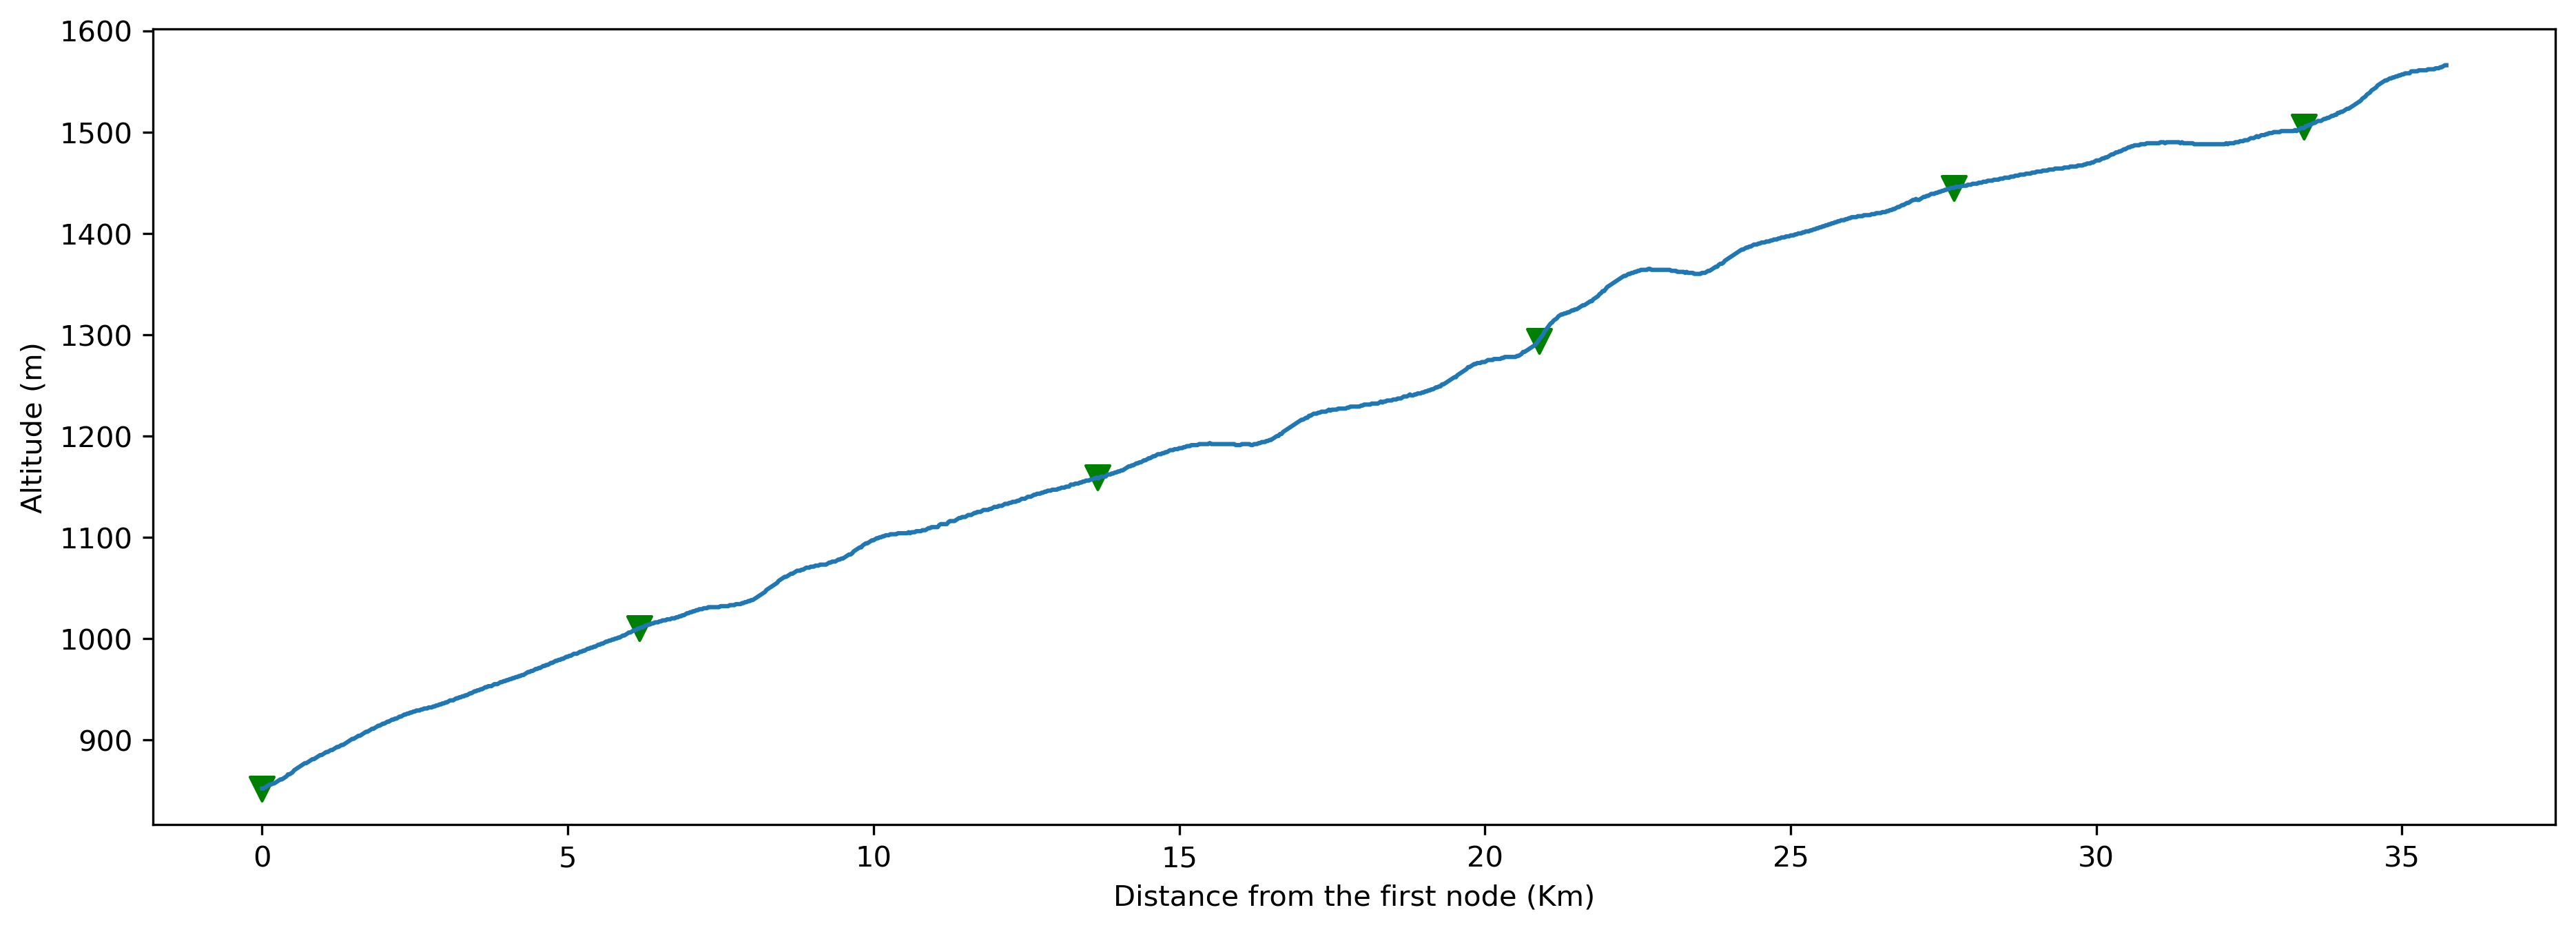

In [54]:
plt.figure(figsize=(15, 5), dpi=300)
plt.scatter(DIST, node_alt, s=70 , c='green', marker='v')
plt.plot(pos, glac_alt)
plt.xlabel('Distance from the first node (Km)')
plt.ylabel('Altitude (m)')
plt.show()